In [37]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


In [168]:
# Import libraries
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical

In [16]:
sf_df = pd.read_csv('zillow_singlefamily_transpose.csv')

In [17]:
sf_df

,10025,60657,10023,77494,60614,77449,10002,77084,79936,60640,11226,10467,78660,94109,10016,37013,32162,60647,11201,11235,11375,90250,78130,37211,10029,10009,77573,60618,77584,10011,20002,10128,28269,78613,77433,78572,30349,79912,75052,94565,...,47464,73019,22807,23173,82938,95721,70792,4033,5405,734,77399,38959,17071,25305,32072,55144,28201,2714,4420,99164,5901,1615,4109,21405,7703,93282,93208,52204,89405,63875,86343,89155,47865,20052,72630,12345,66045,75599,822,801
0,482807,478341,573283,203076,653278,98411,139971,99048,82615,328257,216485,192152,150619,831440,634448,110708,97955,215621,389993,202605,299893,174560,204759,113139,320591,405723,132840,276136,137902,345111,171174,1261689,130530,179353,163661,80425,101795,123671,98191,221186,...,155867,69979,190128,368499,221695,261756,83149,287231,298544,145456,70761,41933,46538,46971,75899,75865,119548,317545,458499,310188,59952,78008,206040,339870,603399,147355,281420,136887,371999,66471,79323,195494,32709,915592,65757,101141,153479,48403,108862,90892
1,493561,476506,590193,203326,650147,98403,141477,99072,82571,325868,215336,191568,150451,833601,637957,111158,98986,215697,391211,202073,298176,174875,199591,113476,320773,416841,133291,275368,138053,348864,169228,1290981,130589,178822,163874,80450,102343,123463,98199,219045,...,156353,70384,192210,369735,222266,260078,82689,287967,302220,145060,70493,41807,46520,47126,74002,74090,123979,318985,461252,311100,60135,78271,205881,341548,596356,146491,280463,136596,366865,67345,78670,195243,32279,916695,67247,100830,152415,48542,108945,91511
2,500744,474880,601917,203127,646667,98361,139864,98997,82540,323848,214261,191330,150347,836753,633514,111542,99335,215778,392263,202295,297269,175233,193582,113824,324880,332746,133874,274669,138621,350954,168149,1299204,130756,178039,163980,80556,102776,123361,98264,218123,...,156983,70238,192571,370199,221477,259166,81602,289790,306263,144755,70398,41738,46662,47241,72949,72886,128627,319684,463349,310967,60487,78945,206749,341415,591388,146162,233823,136524,360177,66995,78560,195242,32074,915274,68648,111866,151732,48601,108824,92742
3,512200,472208,615030,201923,641514,98381,138754,98989,82503,319906,212915,190326,150247,836778,632878,112339,100391,215676,394928,202903,295445,175872,182151,114555,331755,335475,134836,274138,139297,356071,165527,1335846,131255,176795,164442,80808,103673,123182,98392,215944,...,157675,70920,194362,373448,220488,255871,80517,291873,313276,144020,70506,41531,46983,47439,71059,70791,137692,322432,462090,311817,60622,79663,206901,343146,582154,144709,236061,136179,347952,66464,78512,195036,31468,911257,71612,110946,150297,49026,109032,76370
4,517418,468589,616108,200771,633832,98376,135081,98946,82584,316242,212466,189940,150282,835625,639615,113162,100821,214601,395415,204172,294637,176485,172276,115280,332957,338903,135589,272814,139954,360740,164061,1356179,131911,175574,164750,80938,104473,123259,98551,214768,...,158348,71684,193860,381635,219942,254803,80381,293808,318609,143198,70934,41316,46977,47605,69833,69415,134892,321622,456703,312325,61023,80321,208124,343110,571663,143490,239908,135943,337104,65804,79134,194974,31053,904036,74398,110389,150972,49363,109575,77356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,1244859,1027476,1629438,356779,1316119,205443,1082222,204810,146608,794145,1058451,537525,321526,2829785,1152003,267026,294643,606533,3022544,883655,1122199,752857,257451,318742,968985,1144836,291332,588128,277676,2635532,810161,4284486,252688,388536,304556,134142,180772,213688,248448,632676,...,131665,200610,283115,303694,169461,326212,116723,794174,436340,380837,124748,58667,41713,60317,67553,255467,226571,396674,334223,339822,87146,118324,723303,999468,601215,169

# New Section

In [30]:
# set the random seed
np.random.seed(42)
#remove text column headers
data = sf_df.values

Scale the data


In [170]:
from sklearn.preprocessing import MinMaxScaler
data_scaled = MinMaxScaler().fit(data).transform(data)

In [171]:
data_scaled

array([[0.00000000e+00, 7.72976293e-02, 0.00000000e+00, ...,
        4.75777664e-01, 4.75415989e-04, 8.73847811e-01],
       [1.15709558e-02, 7.43163326e-02, 1.19576286e-02, ...,
        4.89954105e-01, 1.51382460e-03, 8.83373086e-01],
       [1.92996312e-02, 7.16745951e-02, 2.02480625e-02, ...,
        4.95971443e-01, 0.00000000e+00, 9.02315919e-01],
       ...,
       [8.08373395e-01, 9.81320999e-01, 7.49770182e-01, ...,
        5.75114737e-01, 7.88727637e-01, 6.41378780e-02],
       [8.02401775e-01, 9.88454990e-01, 7.52777621e-01, ...,
        5.98878123e-01, 7.82647316e-01, 5.45356621e-02],
       [8.01245110e-01, 1.00000000e+00, 7.58969989e-01, ...,
        6.61295258e-01, 7.94032278e-01, 4.37947219e-02]])

Define training/testing/validation cells

In [172]:
train_col = 10000
valid_col = 20000

In [173]:
# split the data into test, training and validation sets
X_train, y_train = data_scaled[:,:train_col], data_scaled[-1,:train_col]
X_valid, y_valid = data_scaled[:,train_col:valid_col], data_scaled[-1,train_col:valid_col]
X_test, y_test = data_scaled[:,valid_col:], data_scaled[-1,valid_col:]

In [174]:
# Add additional dimensions to our arrays to make the series all the same shape
X_train_3d = X_train.transpose()[:,:,np.newaxis]
X_valid_3d = X_valid.transpose()[:,:,np.newaxis]
X_test_3d = X_test.transpose()[:,:,np.newaxis]
y_test_2d = y_test[:,np.newaxis]
y_valid_2d = y_valid[:,np.newaxis]
y_train_2d = y_train[:,np.newaxis]

In [175]:
# Define a function to plot our sample
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])


Saving figure time_series_plot


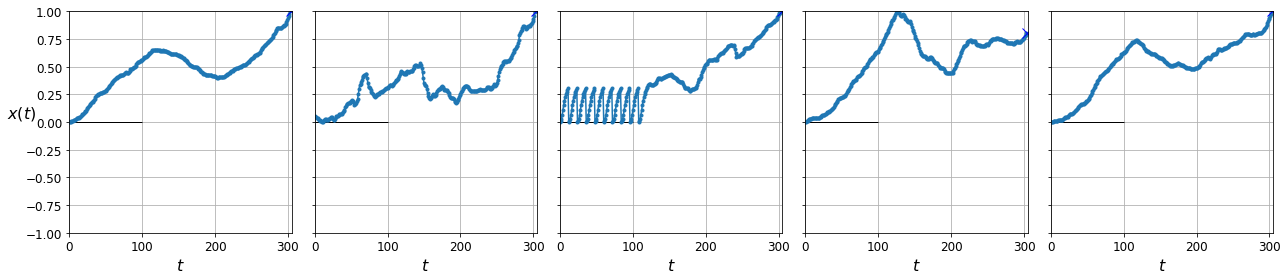

In [176]:
fig, axes = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(18, 4))
for col in range(5):
    plt.sca(axes[col])
    plot_series(X_valid_3d[col, :, 0], y_valid_2d[col, 0],
                y_label=("$x(t)$" if col==0 else None))
save_fig("time_series_plot")
plt.show()
# 'x' in the graphs is what we are trying to predict

Establish a baseline

In [177]:
y_pred = X_valid_3d[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.03448736197823104

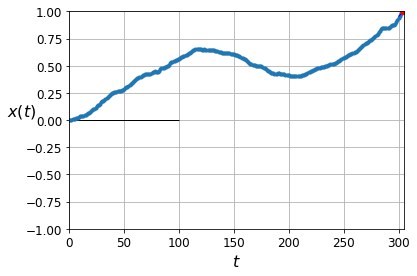

In [178]:
plot_series(X_valid_3d[0, :, 0], y_valid_2d[0, 0], y_pred[0, 0])
plt.show()

In [179]:
np.random.seed(42)
tf.random.set_seed(42)

In [180]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[304, 1]),
    keras.layers.Dense(1)
])

In [181]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 304)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 305       
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [182]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train_3d, y_train_2d, epochs=20,
                    validation_data=(X_valid_3d, y_valid_2d))

Epoch 1/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0186 - val_loss: 0.0193
Epoch 2/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0104
Epoch 3/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0079
Epoch 4/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0053
Epoch 5/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 6/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 7/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 8/20
313/313 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 9/20
313/313 [==============================] - 1s 2ms/step - loss: 8.7279e-04 - val_loss: 0.0020
Epoch 10/20
313/313 [==============================] - 1s 2ms/step - loss: 7.9256e-04 - val_loss

In [183]:
model.evaluate(X_valid_3d, y_valid_2d)
# we want our loss function to be as close to 0 as possible

313/313 [==============================] - 0s 804us/step - loss: 5.6924e-04


0.0005692422855645418